In [2]:
import os

root_path = 'C:/Users/vikto/OneDrive/Documents/code/assignment_imgs'
data_path = 'C:/Users/vikto/OneDrive/Documents/code/assignment_imgs/assignment_imgs'
label_file = os.path.join(root_path, 'label_mapping.csv')
annotation_file = os.path.join(root_path, 'img_annotations.json')
class_name = 'Tomatoes'

In [3]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

imagenet_input_size = (224, 224) 

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
import json
import pandas as pd
import torch.nn.functional as F
from torchvision import transforms, utils
from skimage import io, transform
import numpy as np

class CustomDataset(Dataset):
  def __init__(self, label_file, annotation_file, data_dir, class_name, transform_ops=None):
    self.label_file = label_file
    self.annotation_file = annotation_file
    self.data_dir = data_dir
    self.class_name = class_name
    self.labelling_id = self.find_labelling_id()
    self.transform_ops = transform_ops
    self.dataset = []

    self.parse_dataset()

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_name, label = self.dataset[idx]
    img = io.imread(img_name)

    if self.transform_ops:
      img = self.transform_ops(img)

    return (img, torch.tensor(label))


  def find_labelling_id(self):
    df = pd.read_csv(self.label_file)
    return df.loc[df['labelling_name_en'] == self.class_name]['labelling_id'].iloc[0]


  def parse_dataset(self):
      with open(self.annotation_file) as json_file:
        dataset = []
        without_label = []
        data = json.load(json_file)
      
        for img, objects in data.items():
          contain_label = False
          img_path = os.path.join(self.data_dir, img)
          for obj in objects:
            if obj['id'] == self.labelling_id:
              self.dataset.append((img_path, 1))
              contain_label = True

          if not contain_label:
            without_label.append((img_path, 0))

        self.dataset += random.sample(without_label, k=len(self.dataset))
        random.shuffle(self.dataset)

In [5]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        h, w = sample.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(sample, (new_h, new_w))

        return img

class ToTensor(object):
    def __call__(self, sample):
        image = sample.transpose((2, 0, 1))
        return torch.from_numpy(image)

In [6]:
tfms = transforms.Compose([Rescale(imagenet_input_size), ToTensor(), transforms.Normalize(imagenet_mean, imagenet_std)])
ds = CustomDataset(label_file, annotation_file, data_path, class_name, transform_ops=tfms)

In [7]:
valid_ratio = 0.2
nb_train = int((1.0 - valid_ratio) * len(ds))
nb_valid =  len(ds) - nb_train
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(ds, [nb_train, nb_valid])

In [8]:
batch_size = 4

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

input_cl_size = train_dataset[0][0].shape

In [9]:
import torch.nn as nn
import torchvision

def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)

def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [10]:
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

def conv_layer(ni, nf, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(nf)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(ni, nf, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [11]:
class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 3, stride=stride),
                   conv_layer(nh, nf, 3, zero_bn=True, act=False)
        ] if expansion == 1 else [
                   conv_layer(ni, nh, 1),
                   conv_layer(nh, nh, 3, stride=stride),
                   conv_layer(nh, nf, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [12]:
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, c_in=3, c_out=1):
        nfs = [c_in, (c_in+1)*8, 64, 64]
        stem = [conv_layer(nfs[i], nfs[i+1], stride=2 if i==0 else 1)
            for i in range(3)]

        nfs = [64//expansion,64,128,256,512]
        res_layers = [cls._make_layer(expansion, nfs[i], nfs[i+1],
                                      n_blocks=l, stride=1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        res = cls(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *res_layers,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(nfs[-1]*expansion, c_out),
            nn.Sigmoid(),
        )
        init_cnn(res)
        return res

    @staticmethod
    def _make_layer(expansion, ni, nf, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(n_blocks)])

In [13]:
def xresnet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def xresnet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def xresnet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def xresnet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def xresnet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

In [14]:
from matplotlib import pyplot as plt


class Recorder:
    def __init__(self, f_loss):
        self.epochs = []
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        
        self.current_n = {'train': 0.0, 'valid': 0.0}
        self.current_tot_loss = {'train': 0.0, 'valid': 0.0}
        self.current_correct = {'train': 0.0, 'valid': 0.0}
        
        self.f_loss = f_loss
        
    def train_step(self, N, targets, outputs):
        self.current_n['train'] += N
        self.current_tot_loss['train'] += self.compute_loss(N, targets, outputs)
        self.current_correct['train'] += self.compute_accuracy(targets, outputs)
        
        
    def valid_step(self, N, targets, outputs):
        self.current_n['valid'] += N
        self.current_tot_loss['valid'] += self.compute_loss(N, targets, outputs)
        self.current_correct['valid'] += self.compute_accuracy(targets, outputs)
        
    def compute_loss(self, N, targets, outputs):
        return N * self.f_loss(outputs, targets).item()
        
    def compute_accuracy(self, targets, outputs):
        correct = 0.0
        for target, output in zip(targets, outputs):
                if output[0] >= 0.5:
                  output = torch.tensor([1.0], device=output.device)
                else:
                  output = torch.tensor([0.0], device=output.device)
  
                if target == output:
                  correct += 1.0
            
        return correct
        
    def reset_for_next_epoch(self):
        if len(self.epochs) == 0:
            self.epochs.append(0)
            
        else:
            self.epochs.append(self.epochs[-1] + 1)
        
        
        train_loss = self.current_tot_loss['train'] / self.current_n['train']
        valid_loss = self.current_tot_loss['valid'] / self.current_n['valid']
        
        train_acc = self.current_correct['train'] / self.current_n['train']
        valid_acc = self.current_correct['valid'] / self.current_n['valid']
        
        print(" Train : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
        print(" Validation : Loss : {:.4f}, Acc : {:.4f} \n".format(valid_loss, valid_acc))
        
        self.train_loss.append(train_loss)
        self.val_loss.append(valid_loss)
        self.train_acc.append(train_acc)
        self.val_acc.append(valid_acc)
        
        self.reset()
        
        
    def reset(self):
        self.current_n = {'train': 0.0, 'valid': 0.0}
        self.current_tot_loss = {'train': 0.0, 'valid': 0.0}
        self.current_correct = {'train': 0.0, 'valid': 0.0}
        
        
    def plot(self):
        plt.plot(self.epochs, self.train_loss, 'r', label="Train loss")
        plt.plot(self.epochs, self.train_acc, 'b', label="Train acc")
        plt.plot(self.epochs, self.val_loss, 'g', label="Val loss")
        plt.plot(self.epochs, self.val_acc, 'y', label="Val acc")
        plt.legend()
        plt.show()
        

In [15]:
class Trainer:
    def __init__(self, model, ds_loaders, f_loss, optimizer, scheduler, recorder, use_gpu=True):
        self.model = model
        self.train_loader = ds_loaders[0]
        self.valid_loader = ds_loaders[1]
        self.f_loss = f_loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.use_gpu = use_gpu
        self.recorder = recorder
        
    def fit(self, nb_epochs):
        for i in range(nb_epochs):
            print("Epoch {}".format(i))
            self.train_step()
            self.valid_step()
            self.recorder.reset_for_next_epoch()
        
    def train_step(self):
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            if self.use_gpu:
                inputs, targets = inputs.cuda(), targets.cuda()

            targets = targets.view(-1, 1).float()
            inputs = inputs.to(device=device, dtype=torch.float)

            # Forward
            outputs = self.model(inputs)
            loss = self.f_loss(outputs, targets)

            # Backward and optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            self.recorder.train_step(inputs.shape[0], targets, outputs)
            
        self.scheduler.step()
        
        
    def valid_step(self):
        with torch.no_grad():
            self.model.eval()
            for i, (inputs, targets) in enumerate(valid_loader):
                if self.use_gpu:
                    inputs, targets = inputs.cuda(), targets.cuda()

                    inputs = inputs.to(device=device, dtype=torch.float)
            
                    targets = targets.view(-1, 1).float()
                    outputs = self.model(inputs)

                    self.recorder.valid_step(inputs.shape[0], targets, outputs)

In [16]:
epochs = 100

device = torch.device('cuda')
model = xresnet18(c_out=1)
model.to(device=device)
loss = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [234]:
recorder = Recorder(loss)
trainer = Trainer(model, [train_loader, valid_loader], loss, optimizer, scheduler, recorder, use_gpu=True)

In [235]:
trainer.fit(epochs)

Epoch 0
 Train : Loss : 0.6879, Acc : 0.6124
 Validation : Loss : 0.5547, Acc : 0.7020 

Epoch 1
 Train : Loss : 0.6399, Acc : 0.6667
 Validation : Loss : 0.5904, Acc : 0.6818 

Epoch 2
 Train : Loss : 0.6098, Acc : 0.6932
 Validation : Loss : 0.5995, Acc : 0.6414 

Epoch 3
 Train : Loss : 0.6156, Acc : 0.6629
 Validation : Loss : 0.8556, Acc : 0.7121 

Epoch 4
 Train : Loss : 0.6207, Acc : 0.6818
 Validation : Loss : 0.6619, Acc : 0.6364 

Epoch 5
 Train : Loss : 0.6013, Acc : 0.6806
 Validation : Loss : 0.6722, Acc : 0.7576 

Epoch 6
 Train : Loss : 0.5947, Acc : 0.6894
 Validation : Loss : 0.8009, Acc : 0.6919 

Epoch 7
 Train : Loss : 0.5805, Acc : 0.7172
 Validation : Loss : 0.6178, Acc : 0.6414 

Epoch 8
 Train : Loss : 0.5565, Acc : 0.7184
 Validation : Loss : 0.6052, Acc : 0.6818 

Epoch 9
 Train : Loss : 0.5763, Acc : 0.7525
 Validation : Loss : 0.5964, Acc : 0.7121 

Epoch 10
 Train : Loss : 0.5699, Acc : 0.7222
 Validation : Loss : 0.5898, Acc : 0.6717 

Epoch 11
 Train : Lo

 Train : Loss : 0.3414, Acc : 0.8624
 Validation : Loss : 0.4292, Acc : 0.8283 

Epoch 93
 Train : Loss : 0.3322, Acc : 0.8636
 Validation : Loss : 0.4252, Acc : 0.8485 

Epoch 94
 Train : Loss : 0.3119, Acc : 0.8674
 Validation : Loss : 0.4051, Acc : 0.8384 

Epoch 95
 Train : Loss : 0.3285, Acc : 0.8649
 Validation : Loss : 0.4360, Acc : 0.8434 

Epoch 96
 Train : Loss : 0.3091, Acc : 0.8712
 Validation : Loss : 0.4247, Acc : 0.8434 

Epoch 97
 Train : Loss : 0.2900, Acc : 0.8977
 Validation : Loss : 0.4337, Acc : 0.8232 

Epoch 98
 Train : Loss : 0.2931, Acc : 0.8889
 Validation : Loss : 0.4251, Acc : 0.8333 

Epoch 99
 Train : Loss : 0.3001, Acc : 0.8864
 Validation : Loss : 0.4148, Acc : 0.8434 



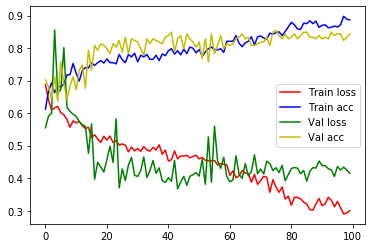

In [236]:
recorder.plot()

In [237]:
save_path = os.path.join(os.getcwd(), 'best_model.pth')
torch.save(model.state_dict(), save_path)

In [201]:
save_path = os.path.join(os.getcwd(), 'best_model.pth')
inference_model = xresnet18(c_out=1)
inference_model.to(device=device)

inference_model.load_state_dict(torch.load(save_path))
inference_model.eval()

XResNet(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convs): Sequential(
        (0): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, mome

In [202]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

In [203]:
inference_model._modules.get('7').register_forward_hook(hook_feature)

In [204]:
def inference(model, sample):
    img, _ = sample
    img = img[None, ...]
    img = img.cuda()
    img = img.to(device=device, dtype=torch.float)
    return model(img)

tensor([[0.8993]], device='cuda:0', grad_fn=<SigmoidBackward>)


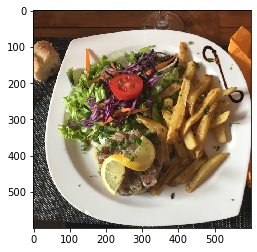

In [350]:
index = random.randint(0, len(ds) - 1)
bunch = ds.dataset[index]
img_name = bunch[0]
img = io.imread(img_name)
plt.imshow(img)
prediction = inference(inference_model, ds[index])
print(prediction)

In [351]:
params = list(inference_model.parameters())
final_weights = np.squeeze(params[-2].data.cpu().numpy())

In [352]:
import cv2

def get_cam(feature_conv, final_weights):
    output_size = (256, 256)
    bz, nc, h, w = feature_conv.shape
    
    cam = final_weights.dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)

    return cv2.resize(cam_img, output_size)

In [353]:
test = get_cam(features_blobs[-1], final_weights)

In [354]:
img = cv2.imread(img_name)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(test, (width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.5 + img * 0.4

In [355]:
cv2.imwrite('CAM.jpg', result)

True